In [1]:
from pathlib import Path
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.models.resnet import Bottleneck, ResNet
import matplotlib.pyplot as plt

In [2]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, data_df, transform=None):
        self.data_dir = data_dir
        self.labels_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.data_dir / f"img_{self.labels_df.iloc[idx]['id']}.png"
        image = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx]['malignant']

        if self.transform:
            image = self.transform(image)
        sample = {'image': image,
                  'label': label,
                  'id': self.labels_df.iloc[idx]['id']}
        return sample

In [4]:
def show_imgs(ims, captions=None):
    fig, ax = plt.subplots(nrows=1, ncols=len(ims), figsize=(10, 5))
    for i in range(len(ims)):
        ax[i].imshow(ims[i])
        ax[i].axis('off')
        if captions is not None:
          ax[i].set_title(captions[i], fontweight="bold")

In [5]:
class ResNetTrunk(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        del self.fc  # remove FC layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x


def get_pretrained_url(key):
    URL_PREFIX = "https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights"
    model_zoo_registry = {
        "BT": "bt_rn50_ep200.torch",
        "MoCoV2": "mocov2_rn50_ep200.torch",
        "SwAV": "swav_rn50_ep200.torch",
    }
    pretrained_url = f"{URL_PREFIX}/{model_zoo_registry.get(key)}"
    return pretrained_url


def resnet50(pretrained, progress, key, **kwargs):
    model = ResNetTrunk(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_url = get_pretrained_url(key)
        verbose = model.load_state_dict(
            torch.hub.load_state_dict_from_url(pretrained_url, progress=progress)
        )
        print(verbose)
    return model



In [6]:
# Set random seed for reproducibility
torch.manual_seed(2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# read in the data
data_dir = Path("/content/data")

In [8]:
# unzip data
! unzip -q /content/data/oxml-carinoma-classification.zip -d /content/data/

In [8]:
labels_file = data_dir / 'labels.csv'
data_df = pd.read_csv(labels_file)

# Transform the class colum to positive values
data_df['malignant'] = data_df['malignant'] + 1
data_df

,id,malignant
0,441,0
1,33284,0
2,38771,2
3,46784,0
4,57613,0
...,...,...
57,918503,0
58,931650,0
59,955514,1
60,965412,0


In [9]:
# see how many we ahve from each class
n_healthy = (data_df['malignant'] == 0).sum() # class 0
n_benign = (data_df['malignant'] == 1).sum() # class 1
n_malign = (data_df['malignant'] == 2).sum() # class 2
data_df['malignant'].value_counts()

0    36
1    14
2    12
Name: malignant, dtype: int64

# Load data

In [59]:
# Define any image transformations if needed
# transform = torchvision.transforms.Compose([...])
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(0.2), # augment the data
    transforms.RandomVerticalFlip(0.2),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # Rescale pixel to [-1, 1] values.
    # The first tuple (0.5, 0.5, 0.5) is the mean for all three
    # channels and the second (0.5, 0.5, 0.5) is the standard
    # deviation for all three channels.
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [60]:
# Create the custom dataset
dataset = CustomDataset(data_dir, data_df, transform)

In [61]:
# Create the data loader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [62]:
sample = next(iter(dataloader))
print(f"Len dataloader: {len(dataloader)}")
print(f"Image shape: {sample['image'].shape} Labels shape: {sample['label'].shape}")

Len dataloader: 4
Image shape: torch.Size([16, 3, 512, 512]) Labels shape: torch.Size([16])


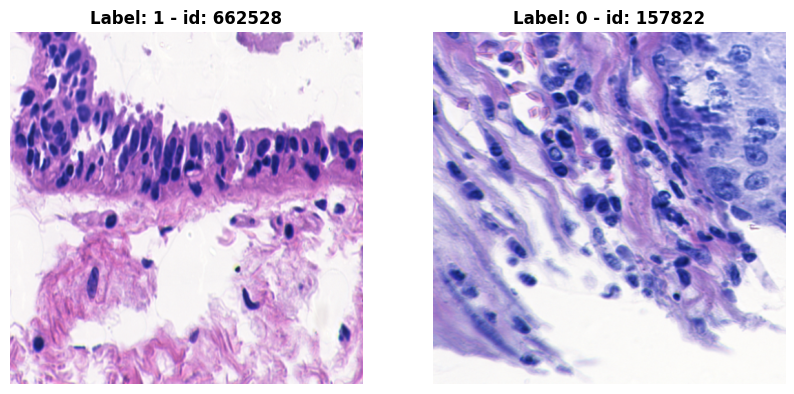

In [63]:
show_imgs([sample["image"][1].permute(1, 2, 0), sample["image"][2].permute(1, 2, 0)],
          captions=[f"Label: {sample['label'][1]} - id: {sample['id'][1]}",
                    f"Label: {sample['label'][2]} - id: {sample['id'][2]}"])

# Get a pre-trained model
Here I will use the models [from](https://github.com/lunit-io/benchmark-ssl-pathology)

In [64]:
# add Fully connected linear layer
class Resnet_fc(nn.Module):
  def __init__(self, pre_trained_model):
    super(Resnet_fc, self).__init__()
    n_classes = 3
    self.model = pre_trained_model
    #self.fc = nn.Sequential(nn.Linear(2048*7, 7),
                            #nn.ReLU(),
                            #nn.Linear(7, 3))
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048*16*16, n_classes))

  def forward(self, x):
    x = self.model(x)
    x = self.fc(x)
    return x

In [65]:
# Size of the last layer from the pretrained model
bla = pre_trained_model(sample["image"].to(device))
bla.shape

torch.Size([16, 2048, 16, 16])

In [66]:
# Create a last fully connected layer to match the number of classes
# Note: the number of of nodes was determined by looking at the network

num_classes = 3
pre_trained_model = resnet50(pretrained=True, progress=False, key="BT")

# Freeze the parameters in the pre-trained network
for param in pre_trained_model.parameters():
    param.requires_grad = False

# Add the fully connected layer that we want to optmize
model = Resnet_fc(pre_trained_model)
model.to(device)


<All keys matched successfully>


Resnet_fc(
  (model): ResNetTrunk(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [67]:
# note that only the last parameters will be optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# Define the loss function
# use weights to balance out the imbalanced classification
weights = [1/n_healthy, 1/n_benign, 1/n_malign]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, patience=50)

In [68]:
num_epochs = 200
epoch_loss_list = []
epoch_lr = []
model.train()
for epoch in range(num_epochs):
  running_loss = 0.0
  print('-' * 10)
  for inputs in dataloader:
    images = inputs["image"].to(device)
    labels = inputs["label"].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

  epoch_loss = running_loss / len(dataloader)
  epoch_loss_list.append(epoch_loss)
  epoch_lr.append(get_lr(optimizer))
  print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}")


----------
Epoch 0/200 - Loss: 2747.7799
----------
Epoch 1/200 - Loss: 5375.4893
----------
Epoch 2/200 - Loss: 3263.1734
----------
Epoch 3/200 - Loss: 6290.0082
----------
Epoch 4/200 - Loss: 1745.2286
----------
Epoch 5/200 - Loss: 2515.6987
----------
Epoch 6/200 - Loss: 1650.4850
----------
Epoch 7/200 - Loss: 1023.5452
----------
Epoch 8/200 - Loss: 809.6570
----------
Epoch 9/200 - Loss: 651.7260
----------
Epoch 10/200 - Loss: 480.0505
----------
Epoch 11/200 - Loss: 692.5884
----------
Epoch 12/200 - Loss: 483.6489
----------
Epoch 13/200 - Loss: 273.2794
----------
Epoch 14/200 - Loss: 79.2123
----------
Epoch 15/200 - Loss: 99.6259
----------
Epoch 16/200 - Loss: 52.5157
----------
Epoch 17/200 - Loss: 107.9927
----------
Epoch 18/200 - Loss: 0.0000
----------
Epoch 19/200 - Loss: 191.9654
----------
Epoch 20/200 - Loss: 0.0000
----------
Epoch 21/200 - Loss: 164.7171
----------
Epoch 22/200 - Loss: 8.0500
----------
Epoch 23/200 - Loss: 17.5005
----------
Epoch 24/200 - Lo

KeyboardInterrupt: ignored

Text(0, 0.5, 'Loss')

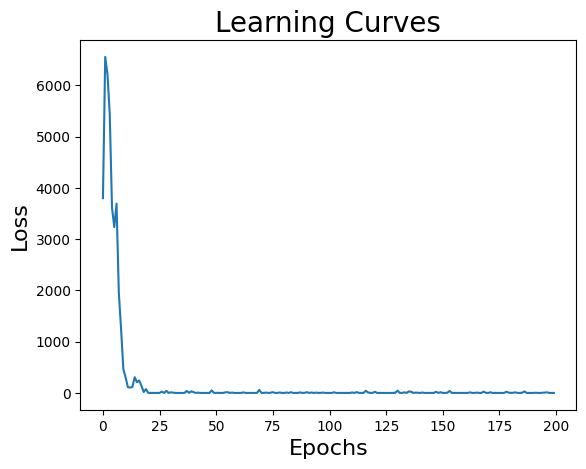

In [53]:
plt.plot(epoch_loss_list)
plt.title("Learning Curves", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

Text(0, 0.5, 'Loss')

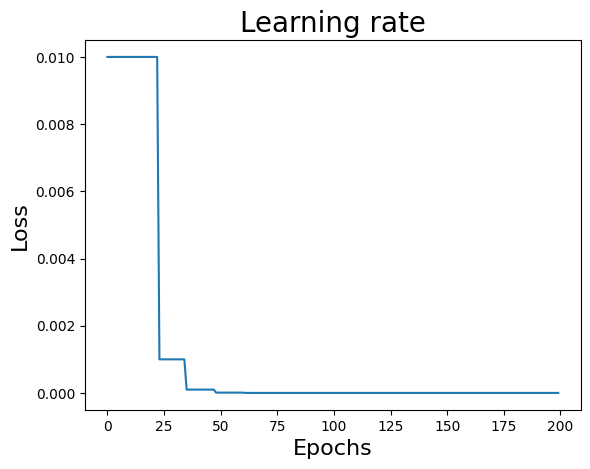

In [54]:
plt.plot(epoch_lr)
plt.title("Learning rate", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

# Get the test labels

In [55]:
output = {}

output_df = pd.DataFrame(columns=['id', 'malignant'])
images_files = data_dir.glob("*.png")
# remove files that we have labels for
training_ids = data_df['id'].to_list()
test_ids = []
for idx, image_file in enumerate(images_files):
  id = int(image_file.stem.split('_')[1])
  if id not in training_ids:
    test_ids.append(id)

    # Load image
    image = Image.open(image_file).convert('RGB')
    data = transform(image).to(device)
    # Add Batch dimension
    data = torch.unsqueeze(data, 0)

    # pass image to the model
    label = torch.argmax(model(data)).cpu().detach().numpy() - 1

    output_df.loc[idx] = [id, label]

print(f'Number of unlabelled images: {len(test_ids)}')

Number of unlabelled images: 124


In [56]:
output_df

,id,malignant
1,467694,-1
2,812227,-1
3,67212,-1
5,346084,-1
6,97549,-1
...,...,...
178,791719,-1
180,74995,-1
183,957521,-1
184,125877,-1


In [57]:
output_df['malignant'].value_counts()

-1    122
 0      1
 1      1
Name: malignant, dtype: int64

In [58]:
# save output
output_df.to_csv(data_dir / 'predictions.csv', index=False)